# PAN - Atribuição Autoral - 2018 - Modelo Char wb



In [1]:
%matplotlib inline

In [2]:
#python basic libs
import os;
from os.path import join as pathjoin;
import zipfile;

import re;
import random;
import json;
from collections import defaultdict, Counter;
from pprint import pprint
from time import time

In [3]:
#data analysis libs
import numpy as np;
import pandas as pd;
from pandas.plotting import scatter_matrix;
import matplotlib.pyplot as plt;


import seaborn as sns;

In [4]:
#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import feature_selection;

#preprocessing and transformation
from sklearn import preprocessing;
from sklearn.preprocessing import MaxAbsScaler;
from sklearn.decomposition import PCA;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression


#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score;

NLP Libs

In [5]:
# import spacy;
# import nltk;
# import gensim
# import logging
# from gensim.models import KeyedVectors
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [6]:
from IPython.display import Markdown, display, HTML

libraries configurations

In [7]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format
sns.set(color_codes=True);

In [9]:
import platform;
import sklearn;
import scipy;

Markdown(
    "|%-15s|%-65s|\n"%("PACK","VERSION") +
    "|%-15s|%-65s|\n"%('-'*15,'-'*65) +
    ('\n'.join(
    "|%-15s|%-45s| " % (pack, version.strip())
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__])

)))

|PACK           |VERSION                                                          |
|---------------|-----------------------------------------------------------------|
|SO             |Darwin-18.2.0-x86_64-i386-64bit              | 
|NumPy          |1.15.4                                       | 
|SciPy          |1.1.0                                        | 
|Scikit-Learn   |0.20.1                                       | 
|Seaborn        |0.9.0                                        | 

In [10]:
import seaborn as sns;
sns.set(color_codes=True);

In [11]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
print("seaborn", sns.__version__)

Darwin-18.2.0-x86_64-i386-64bit
NumPy 1.15.4
SciPy 1.1.0
Scikit-Learn 0.20.1
seaborn 0.9.0


In [12]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format

In [13]:
from skleanExtensions import DenseTransformer

### paths configuration

In [14]:
baseDir = '../';

corpusTraining    = 'pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02';
corpusEvaluation = 'pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20';
corpusEach1 = 'Lyrics_AA_PT';

currentCorpus = corpusTraining;

inputDir= pathjoin(baseDir,currentCorpus);
outputDir= pathjoin(baseDir,'out');
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [15]:
import pan

In [16]:
problems = pan.readCollectionsOfProblemsFromZip(inputDir + '.zip');

In [17]:
problems[0]['problem']

'problem00001'

In [18]:
pd.DataFrame(problems)[['problem','language','authorCount','candidates','unknown']]

,problem,language,authorCount,candidates,unknown
0,problem00001,en,20,"[[graceful ones.\n\n""One more,"" Marvelous said...","[[a word it said, not wanting to see them anym..."
1,problem00002,en,5,"[[a mission.""\n\nJensen just raises an eyebrow...","[[don't mean you, technically, but it's just t..."
2,problem00003,fr,20,[[qui l'avait tué mais tout était de la faute ...,[[scène qui se déroulait entre leurs bras. Le ...
3,problem00004,fr,5,[[. Le canapé est vide et lorsqu'il passe deva...,"[[lui. Le silence m'insupporte et rapidement, ..."
4,problem00005,it,20,"[[Eppure lui la mappa l’aveva stampata, dannaz...",[[nella sua prima casa da solo.\nAveva usato a...
5,problem00006,it,5,[[Yato ha trovato una lettera sul suo comodino...,"[[Bah, dà qua, che peggio di così non può anda..."
6,problem00007,pl,20,[[zmienił zdanie. Niech się stworzonko pobawi....,"[[Przynajmniej tak sądził chłopak, dopóki nie ..."
7,problem00008,pl,5,"[[Słowem, które Sherlock najczęściej słyszał w...",[[zamknął oczy. Serce waliło mu jak oszalałe; ...
8,problem00009,sp,20,[[pero no lo ama como ama a Guignol –explicó e...,"[[de tanto contacto entre ellos, fue que Albus..."
9,problem00010,sp,5,"[[incapaz de señalar un momento exacto, un pun...","[[editores son magos, así que tiene el peor hu..."


### examinando o parametro min_df isoladamente

In [19]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _  = zip(*problem['candidates'])
    test_docs, test_labels, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='word',
                                   max_df=1.0,
                                   norm='l1',
                                   ngram_range=(1,3),
                                   sublinear_tf=True,
                                   smooth_idf=True,
                                   lowercase =False)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(0.01,0.05,0.1)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               iid=False,
                               verbose=False,
                               scoring='f1_macro'
                              )
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("GridSearch: %0.3fs" % (time() - t0), end=' ')
    print("Best score: %0.3f" % grid_search.best_score_, end=' ')
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    f1 = f1_score(test_labels,test_pred, average='macro')
    precision = precision_score(test_labels,test_pred, average='macro')
    recall =  recall_score(test_labels,test_pred, average='macro')
    accuracy =   accuracy_score(test_labels,test_pred)
    
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

In [20]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b = runML(problem);
        result.append(r);
        cv_result.append(c);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  GridSearch: 6.937s Best score: 0.462 Best parameters set:
	vect__min_df: 0.01

Problem: problem00002,  language: en,  GridSearch: 1.412s Best score: 0.664 Best parameters set:
	vect__min_df: 0.1

Problem: problem00003,  language: fr,  GridSearch: 6.107s Best score: 0.563 Best parameters set:
	vect__min_df: 0.05

Problem: problem00004,  language: fr,  GridSearch: 1.441s Best score: 0.762 Best parameters set:
	vect__min_df: 0.01

Problem: problem00005,  language: it,  GridSearch: 7.674s Best score: 0.365 Best parameters set:
	vect__min_df: 0.01

Problem: problem00006,  language: it,  GridSearch: 2.912s Best score: 0.644 Best parameters set:
	vect__min_df: 0.01

Problem: problem00007,  language: pl,  GridSearch: 7.213s Best score: 0.447 Best parameters set:
	vect__min_df: 0.05

Problem: problem00008,  language: pl,  GridSearch: 1.551s Best score: 0.500 Best parameters set:
	vect__min_df: 0.01

Problem: problem00009,  language: sp,  GridSearch: 8.132

In [21]:
for c,p in zip(cv_result, problems):
    c['problem'] = p['problem']
df =  pd.concat([
    pd.DataFrame(c) for c in cv_result
])
df = df[df.rank_test_score == 1]

df = df[['problem', 'mean_test_score','std_test_score','param_vect__min_df']]
df.sort_values(['problem','mean_test_score','param_vect__min_df'])

,problem,mean_test_score,std_test_score,param_vect__min_df
0,problem00001,0.4616,0.0532,0.0100
2,problem00002,0.6644,0.0974,0.1000
1,problem00003,0.5628,0.0384,0.0500
0,problem00004,0.7622,0.2049,0.0100
1,problem00004,0.7622,0.2049,0.0500
0,problem00005,0.3652,0.0630,0.0100
0,problem00006,0.6444,0.1257,0.0100
1,problem00006,0.6444,0.1257,0.0500
1,problem00007,0.4470,0.0804,0.0500
0,problem00008,0.5000,0.0000,0.0100


### analisando os demais parametros

In [24]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _ = zip(*problem['candidates'])
    test_docs, test_labels, test_filename = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='word',
                                   min_df=0.01,
                                   max_df=1.0,
                                   norm='l1')),
        ('scaler', MaxAbsScaler()),
        ('dense',  DenseTransformer()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((1,1),(1,2),(1,3)),
        'vect__use_idf'     :(True, False),
        'vect__sublinear_tf':(True, False),
        'vect__smooth_idf'  :(True, False),
        'vect__norm'        :('l1','l2'),
        'vect__lowercase'   :(True,False)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               iid=False,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("Gridsearh %0.3fs" % (time() - t0), end=' ')

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    print("'"+problem['language']+"':{")
    for param_name in sorted(parameters.keys()):
        print("\t'%s': %r," % (param_name, best_parameters[param_name]))
    print("},")
    
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    f1        = f1_score       (test_labels,test_pred, average='macro');
    precision = precision_score(test_labels,test_pred, average='macro');
    recall    = recall_score   (test_labels,test_pred, average='macro');
    accuracy  = accuracy_score (test_labels,test_pred);
    
    def mean(a):
        return sum(a)/len(a);
    
    
    return {
                'problem'  :       problem['problem'],
                "language"      :       problem['language'],
                'authorCount'   :       len(set(train_labels)),
        
                "train_doc_size":       len(train_docs),
                "train_doc_per_author": mean(Counter(train_labels).values()) ,
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),        
        
                "test_doc_size" :       len(test_docs),
                "test_doc_per_author": mean(Counter(test_labels).values()) ,
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'f1'       : round(f1,3),
                'precision': round(precision,3),
                'recall'   : round(recall,3),
                'accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters, grid_search.best_estimator_;

In [25]:
result = [];
cv_result = [];
best_parameters = [];
estimators = [];
for problem in problems:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore");
        r, c, b, e = runML(problem);
        result.append(r);
        cv_result.append(c);
        estimators.append(e);
        b['problem'] = problem['problem'];
        best_parameters.append(b);


Problem: problem00001,  language: en,  Gridsearh 98.932s Best score: 0.555
Best parameters set:
'en':{
	'vect__lowercase': True,
	'vect__ngram_range': (1, 2),
	'vect__norm': 'l1',
	'vect__smooth_idf': True,
	'vect__sublinear_tf': False,
	'vect__use_idf': True,
},

Problem: problem00002,  language: en,  Gridsearh 13.799s Best score: 0.818
Best parameters set:
'en':{
	'vect__lowercase': True,
	'vect__ngram_range': (1, 2),
	'vect__norm': 'l1',
	'vect__smooth_idf': True,
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},

Problem: problem00003,  language: fr,  Gridsearh 101.078s Best score: 0.609
Best parameters set:
'fr':{
	'vect__lowercase': True,
	'vect__ngram_range': (1, 2),
	'vect__norm': 'l2',
	'vect__smooth_idf': True,
	'vect__sublinear_tf': True,
	'vect__use_idf': True,
},

Problem: problem00004,  language: fr,  Gridsearh 14.740s Best score: 0.876
Best parameters set:
'fr':{
	'vect__lowercase': True,
	'vect__ngram_range': (1, 2),
	'vect__norm': 'l2',
	'vect__smooth_idf': True

In [26]:
df=pd.DataFrame(result)[['problem',
                     "language",
                     'authorCount',
                     "train_doc_size",
                     "test_doc_size", 
                     'f1','precision','recall' ,'accuracy']]
df

,problem,language,authorCount,train_doc_size,test_doc_size,f1,precision,recall,accuracy
0,problem00001,en,20,80,105,0.3790,0.3970,0.4970,0.5140
1,problem00002,en,5,20,21,0.4300,0.3900,0.5500,0.7140
2,problem00003,fr,20,80,49,0.2760,0.3070,0.3680,0.3470
3,problem00004,fr,5,20,21,0.4070,0.5120,0.4470,0.4760
4,problem00005,it,20,80,80,0.3540,0.3480,0.4680,0.3880
5,problem00006,it,5,20,46,0.4010,0.4710,0.5320,0.5430
6,problem00007,pl,20,80,103,0.3150,0.3570,0.3290,0.3790
7,problem00008,pl,5,20,15,0.6650,0.6420,0.7560,0.7330
8,problem00009,sp,20,80,117,0.4670,0.4950,0.5900,0.5470
9,problem00010,sp,5,20,64,0.6220,0.6420,0.6430,0.6880


In [27]:
df[['f1']].mean()

f1   0.4316
dtype: float64

In [28]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [29]:
for c,p in zip(cv_result, problems):
    c['problem'] = p['problem']
    c['authorCount'] = p ['authorCount']
    c['language'] = p ['language']
dfCV =  pd.concat([
    pd.DataFrame(c) for c in cv_result
])

params = {
    'param_vect__ngram_range':'ngram_range',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__use_idf':'use_idf',
    'param_vect__norm':'norm',
    'param_vect__lowercase':'lowercase'
}
dfCV = dfCV[['problem','language', 'authorCount','rank_test_score', 'mean_test_score','std_test_score'] + list(params.keys())].rename(columns=params)
dfCV.problem = dfCV.problem.apply(lambda x: re.sub(r'\D','',x))
dfCV.sort_values(['problem','mean_test_score'],ascending=[True,False], inplace=True)
dfCV[dfCV.rank_test_score == 1]

,problem,language,authorCount,rank_test_score,mean_test_score,std_test_score,ngram_range,sublinear_tf,use_idf,norm,lowercase
18,00001,en,20,1,0.5546,0.1035,"(1, 2)",False,True,l1,True
22,00001,en,20,1,0.5546,0.1035,"(1, 2)",False,True,l1,True
16,00002,en,5,1,0.8178,0.1290,"(1, 2)",True,True,l1,True
17,00002,en,5,1,0.8178,0.1290,"(1, 2)",True,False,l1,True
18,00002,en,5,1,0.8178,0.1290,"(1, 2)",False,True,l1,True
20,00002,en,5,1,0.8178,0.1290,"(1, 2)",True,True,l1,True
21,00002,en,5,1,0.8178,0.1290,"(1, 2)",True,False,l1,True
22,00002,en,5,1,0.8178,0.1290,"(1, 2)",False,True,l1,True
32,00002,en,5,1,0.8178,0.1290,"(1, 3)",True,True,l1,True
34,00002,en,5,1,0.8178,0.1290,"(1, 3)",False,True,l1,True


## Saving the model

In [30]:
dfCV.to_csv('PANAA2018_word.csv', index=False,compression='zip')

In [31]:
dfCV = pd.read_csv('PANAA2018_word.csv', na_values='',compression='zip')

In [32]:
import pickle;
with open("PANAA2018_word.pkl","wb") as f:
    pickle.dump(estimators,f)

# Understanding the estimators

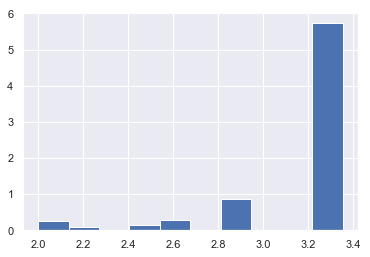

In [98]:
plt.hist(np.clip(estimators[7].named_steps['vect'].idf_,2,100), bins=10,density=True);

In [64]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [129]:
def explainEstimator(est, top=5):
    #idf = est.named_steps['vect'].idf_;
    vect = {i:v for v,i in est.named_steps['vect'].vocabulary_.items()};
    ngrams = {i:len(v.split()) for v,i in est.named_steps['vect'].vocabulary_.items()};
    print(est.named_steps['vect'].ngram_range)

    pca = est.named_steps['transf'].components_;
    clf = est.named_steps['clf'].coef_;
    classes = est.named_steps['clf'].classes_;
    
    relevancy = clf.dot(pca);
    relevancy = relevancy / np.abs(relevancy).max(axis=1).reshape(-1,1)
    
    for v,c in zip(['pca','clf','rel'],[pca,clf,relevancy]):
        print(v,type(c),c.shape);
        
    
    nrels =[]
        
    for _class, rel in zip(classes,relevancy):
        order = np.argsort(rel)
        order = np.hstack([order[0:top],order[-top:]]);
        print("\n\nClass %s" % _class);
        pandas_df_to_markdown_table(
            pd.DataFrame([(vect[i], round(rel[i],4),ngrams[i]) for i in order], columns=['feature','weight','ngrams'])
        )
        nrel = [np.sum([abs(r) for i,r in enumerate(rel) if ngrams[i]==n]) for n in sorted(list(set(ngrams.values())))]
        nrels.append(nrel)
    
    nrels = np.array(nrels);
    nrels = nrels /nrels.sum(axis=1).reshape(-1,1);
    nrels = np.round(nrels*100,2);
    pandas_df_to_markdown_table(
        pd.DataFrame(nrels,index=classes,columns=sorted(list(set(ngrams.values())))).reset_index()
    )
    
explainEstimator(estimators[0])

(1, 2)
pca <class 'numpy.ndarray'> (79, 45612)
clf <class 'numpy.ndarray'> (20, 79)
rel <class 'numpy.ndarray'> (20, 45612)


Class candidate00001


feature|weight|ngrams
---|---|---
been|-0.4874|1
over|-0.4001|1
on the|-0.3925|2
let|-0.3464|1
of the|-0.3303|2
so she|0.8341|2
at her|0.8558|2
she said|0.8615|2
the next|0.9324|2
her with|1.0|2




Class candidate00002


feature|weight|ngrams
---|---|---
over|-0.3271|1
in the|-0.2917|2
then|-0.2851|1
more|-0.2817|1
until|-0.2744|1
anders|0.8595|1
down the|0.8653|2
protested|0.9306|1
hands and|0.9504|2
warden|1.0|1




Class candidate00003


feature|weight|ngrams
---|---|---
now|-0.3519|1
at|-0.322|1
one|-0.3108|1
more|-0.3051|1
his face|-0.3034|2
seemed to|0.7272|2
and they|0.7403|2
they had|0.7885|2
replied with|0.9113|2
seemed|1.0|1




Class candidate00004


feature|weight|ngrams
---|---|---
and he|-0.382|2
his face|-0.3602|2
own|-0.3515|1
between|-0.334|1
eyes|-0.3321|1
he murmured|0.7992|2
evidence|0.7992|1
by sherlock|0.7992|2
that sherlock|0.7992|2
worn|1.0|1




Class candidate00005


feature|weight|ngrams
---|---|---
so|-0.3715|1
that|-0.3548|1
sure|-0.3245|1
have|-0.3163|1
there|-0.3119|1
stood|0.7717|1
both|0.8717|1
stood and|0.9239|2
turned and|0.9926|2
chibs|1.0|1




Class candidate00006


feature|weight|ngrams
---|---|---
with|-0.3326|1
and he|-0.3314|2
as he|-0.3123|2
own|-0.3056|1
here|-0.2921|1
made him|0.9003|2
due to|0.9859|2
confirmed|1.0|1
orbs|1.0|1
the taller|1.0|2




Class candidate00007


feature|weight|ngrams
---|---|---
his hands|-0.3354|2
own|-0.3129|1
hands|-0.3074|1
there|-0.3003|1
in|-0.2977|1
me to|0.7441|2
usual|0.8631|1
killed|0.9044|1
and leaned|0.9962|2
vampire|1.0|1




Class candidate00008


feature|weight|ngrams
---|---|---
only|-0.3192|1
so|-0.307|1
another|-0.3026|1
like that|-0.2809|2
anything|-0.2769|1
pyotr alec|0.6896|2
control|0.7095|1
voice was|0.7257|2
appeared|0.8742|1
involved in|1.0|2




Class candidate00009


feature|weight|ngrams
---|---|---
was|-0.4802|1
had|-0.4439|1
face|-0.3319|1
and the|-0.3132|2
own|-0.2963|1
out and|0.8908|2
thrusting|0.9402|1
cock in|0.9529|2
not going|0.9838|2
he says|1.0|2




Class candidate00010


feature|weight|ngrams
---|---|---
him|-0.4651|1
his|-0.4013|1
he|-0.3855|1
face|-0.3828|1
his face|-0.3386|2
regina|0.7996|1
own|0.823|1
spoken|0.9834|1
and regina|1.0|2
as regina|1.0|2




Class candidate00011


feature|weight|ngrams
---|---|---
was|-0.3418|1
be|-0.3362|1
had|-0.3358|1
anything|-0.2721|1
been|-0.2654|1
dean|0.8525|1
cas|0.8548|1
glance|0.9277|1
picks|0.9748|1
dean just|1.0|2




Class candidate00012


feature|weight|ngrams
---|---|---
can|-0.2702|1
they|-0.2634|1
took|-0.2627|1
the first|-0.2474|2
longer|-0.2473|1
he would|0.7574|2
even if|0.7959|2
quickly|0.8271|1
moment to|0.9183|2
laughed bit|1.0|2




Class candidate00013


feature|weight|ngrams
---|---|---
way|-0.356|1
his hands|-0.3474|2
that|-0.306|1
like that|-0.2957|2
until|-0.2844|1
and half|0.7165|2
ll let|0.7165|2
michael|0.7256|1
tears|0.7859|1
burst|1.0|1




Class candidate00014


feature|weight|ngrams
---|---|---
if|-0.302|1
through|-0.2798|1
took|-0.2659|1
all the|-0.2637|2
else|-0.2625|1
down until|0.6813|2
watching his|0.6841|2
nine|0.6866|1
virgin when|0.6886|2
stripe|1.0|1




Class candidate00015


feature|weight|ngrams
---|---|---
couldn|-0.4111|1
off|-0.4058|1
some|-0.3911|1
only|-0.3857|1
took|-0.3823|1
he shook|0.9749|2
time the|0.9749|2
satisfied|0.977|1
anyway he|0.9994|2
scratched|1.0|1




Class candidate00016


feature|weight|ngrams
---|---|---
at the|-0.4056|2
on|-0.3747|1
sure|-0.3699|1
his|-0.3584|1
looking|-0.352|1
saying you|0.7876|2
him right|0.7876|2
you|0.7891|1
what you|0.8269|2
any of|1.0|2




Class candidate00017


feature|weight|ngrams
---|---|---
out|-0.4905|1
back|-0.4561|1
into|-0.3668|1
have|-0.3599|1
look|-0.342|1
there were|0.8276|2
he used|0.8301|2
tune|0.8301|1
whole|0.9473|1
the whole|1.0|2




Class candidate00018


feature|weight|ngrams
---|---|---
before|-0.3172|1
looking|-0.314|1
had|-0.311|1
couldn|-0.2847|1
it was|-0.2843|2
looks|0.7553|1
open|0.9094|1
stroking|0.9245|1
around him|0.951|2
pulls|1.0|1




Class candidate00019


feature|weight|ngrams
---|---|---
and he|-0.3761|2
his hands|-0.3705|2
up|-0.3648|1
on the|-0.3564|2
hands|-0.3396|1
fall|0.8296|1
the last|0.8555|2
do this|0.9127|2
were more|0.9811|2
armor|1.0|1




Class candidate00020


feature|weight|ngrams
---|---|---
too|-0.4041|1
and he|-0.3839|2
his hands|-0.3772|2
one|-0.3567|1
even|-0.3521|1
meals|0.8111|1
whispered in|0.8111|2
naturedly|0.8111|1
making sure|0.939|2
sure the|1.0|2


index|1|2
---|---|---
candidate00001|20.81|79.19
candidate00002|20.79|79.21
candidate00003|19.9|80.1
candidate00004|20.28|79.72
candidate00005|21.28|78.72
candidate00006|20.81|79.19
candidate00007|20.07|79.93
candidate00008|20.41|79.59
candidate00009|20.53|79.47
candidate00010|19.72|80.28
candidate00011|21.25|78.75
candidate00012|19.52|80.48
candidate00013|19.51|80.49
candidate00014|20.03|79.97
candidate00015|19.85|80.15
candidate00016|19.68|80.32
candidate00017|20.1|79.9
candidate00018|20.46|79.54
candidate00019|20.45|79.55
candidate00020|21.59|78.41


In [159]:
def explainEstimator(est, top=5):
    #idf = est.named_steps['vect'].idf_;
    vect = {i:v for v,i in est.named_steps['vect'].vocabulary_.items()};
    ngrams = {i:len(v.split()) for v,i in est.named_steps['vect'].vocabulary_.items()};
    print(est.named_steps['vect'].ngram_range)

    pca = est.named_steps['transf'].components_;
    clf = est.named_steps['clf'].coef_;
    classes = est.named_steps['clf'].classes_;
    
    relevancy = clf.dot(pca);
    relevancy = relevancy / np.abs(relevancy).max(axis=1).reshape(-1,1)
    
    for v,c in zip(['pca','clf','rel'],[pca,clf,relevancy]):
        print(v,type(c),c.shape);
        
    
    nrels =[];
    bestFeatures = [];
        
    for _class, rel in zip(classes,relevancy):
        order = np.argsort(rel)
        order = np.hstack([order[0:top],order[-top:]]);
        
        bestFeatures.append([vect[i] for i in order]);
        nrel = [np.sum([abs(r) for i,r in enumerate(rel) if ngrams[i]==n]) for n in sorted(list(set(ngrams.values())))]
        nrels.append(nrel)
    
    nrels = np.array(nrels);
    nrels = nrels /nrels.sum(axis=1).reshape(-1,1);
    nrels = np.round(nrels*100,2);
    pandas_df_to_markdown_table(
        pd.DataFrame(nrels,index=classes,columns=sorted(list(set(ngrams.values())))).T.reset_index()
    )
    
    
    pandas_df_to_markdown_table(
        pd.DataFrame(np.array(bestFeatures).T, columns=classes).T.reset_index()
    )
    
explainEstimator(estimators[1])

(1, 2)
pca <class 'numpy.ndarray'> (19, 14540)
clf <class 'numpy.ndarray'> (5, 19)
rel <class 'numpy.ndarray'> (5, 14540)


index|candidate00001|candidate00002|candidate00003|candidate00004|candidate00005
---|---|---|---|---|---
1|23.06|23.37|23.95|22.38|22.62
2|76.94|76.63|76.05|77.62|77.38


index|0|1|2|3|4|5|6|7|8|9
---|---|---|---|---|---|---|---|---|---|---
candidate00001|had|was|her|she|were|cock in|he can|says|not going|he says
candidate00002|on the|been|over|is|sound|so she|was to|the next|he was|her with
candidate00003|too|even|and he|hands|tried|been|his own|you are|around the|sure the
candidate00004|right|if|if he|good|through|his face|shoulders|yeah|his breath|stripe
candidate00005|at the|me|now|around the|care|holding|seemed to|replied with|had the|seemed


## understanding the model with reports

Podemos ver que para um mesmo problema mais de uma configuração é possível

In [147]:
with pd.option_context('display.precision', 4):
    html = (dfCV.pivot_table(
                index=['problem','language'],
                columns=['ngram_range','lowercase','use_idf','sublinear_tf','norm'],
                values='mean_test_score',aggfunc='mean'
                
            ).T.style.background_gradient(axis=0, cmap=plt.cm.Blues))
html

In [148]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV.pivot_table(
                index=['problem','language'],
                columns=['ngram_range','sublinear_tf','use_idf','norm'],
                values='mean_test_score',aggfunc='mean'
                
            ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & ngram\_range & \multicolumn{8}{l}{(1, 1)} & \multicolumn{8}{l}{(1, 2)} & \multicolumn{8}{l}{(1, 3)} \\
 & sublinear\_tf & \multicolumn{4}{l}{False} & \multicolumn{4}{l}{True} & \multicolumn{4}{l}{False} & \multicolumn{4}{l}{True} & \multicolumn{4}{l}{False} & \multicolumn{4}{l}{True} \\
 & use\_idf & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} & \multicolumn{2}{l}{False} & \multicolumn{2}{l}{True} \\
 & norm & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 & l1 & l2 \\
problem & language & & & & & & & & & & & & & & & & & & & & & & & & \\
\midrule
1 & en & 0.4554 & 0.4254 & 0.4384

In [149]:
dfCV.ngram_range[0]

'(1, 2)'

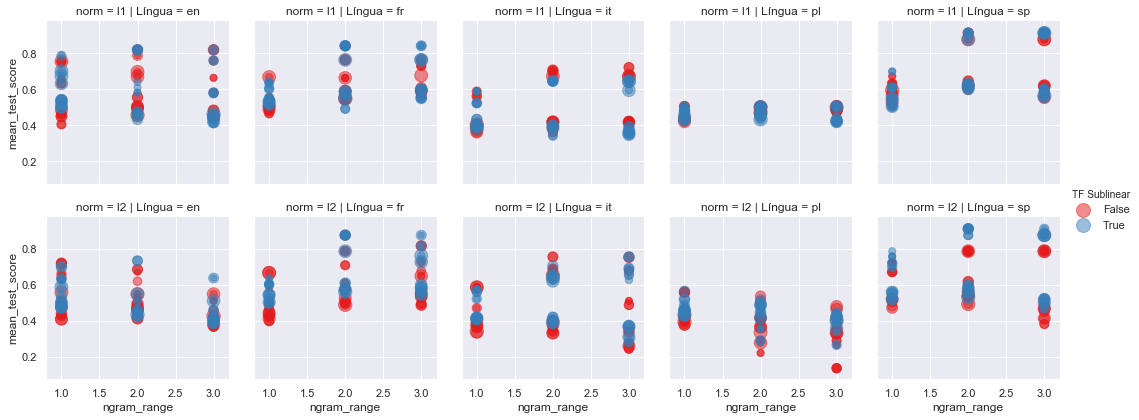

In [150]:
d = dfCV.copy()
d = d.rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
d.ngram_range = d.ngram_range.apply(lambda x: int(re.sub(r'(.*,)|\D',r'',x)))
#d.ngram_range = d.apply(lambda x: str(x[u'ngram_range'][0]) +" "+ str(x[u'ngram_range'][1]), axis=1)

d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, col='Língua', hue='TF Sublinear',  row="norm", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score",alpha=0.5, s=d.std_test_score.values/2).add_legend();
#sns.pairplot(d, hue="TF Sublinear", vars=["autorNumber", "mean_test_score"])


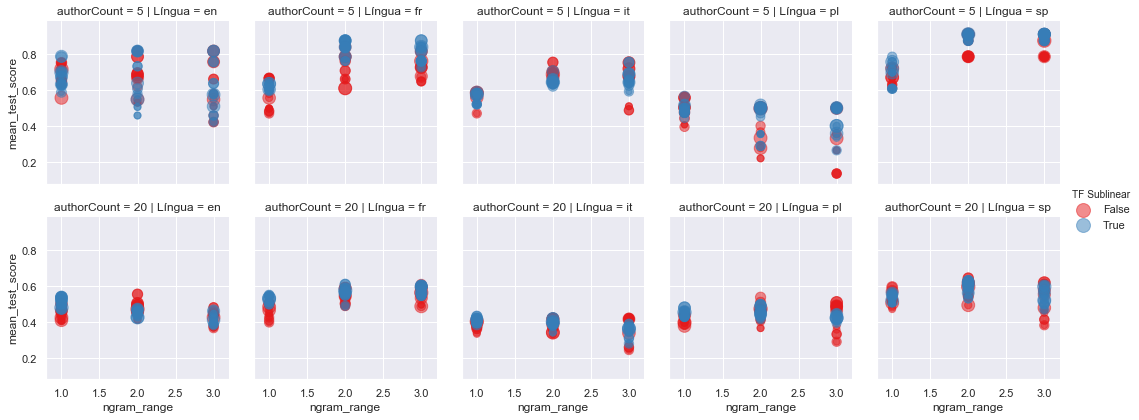

In [151]:
g = sns.FacetGrid(d, row='authorCount', hue='TF Sublinear',  col=u"Língua", height=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values/2).add_legend();

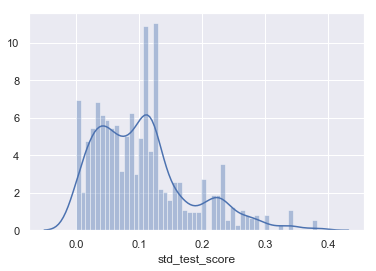

In [152]:
sns.distplot(dfCV.std_test_score, bins=50);

In [153]:
import statsmodels.api as sm

In [154]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range','use_idf','lowercase']].copy();

d.lowercase=d.lowercase.apply(lambda x: 1 if x else 0)
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d.use_idf     =d.use_idf.apply(lambda x: 1 if x else 0)
d.norm        =d.norm.apply(lambda x: 1 if x == 'l1' else 0)

d.norm.fillna(value='None', inplace=True);

d.ngram_range = d.ngram_range.apply(lambda x: int(re.sub(r'(.*,)|\D',r'',x))).astype(np.uint8)
d.drop(columns=['problem'], inplace=True)
d['intercept'] = 1;

#d.mean_test_score = np.log(d.mean_test_score/(1-d.mean_test_score))

d=pd.get_dummies(d, columns=['language'])

In [155]:
d.describe()

,mean_test_score,sublinear_tf,norm,ngram_range,use_idf,lowercase,intercept,language_en,language_fr,language_it,language_pl,language_sp
count,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000,960.0000
mean,0.5574,0.5000,0.5000,2.0000,0.5000,0.5000,1.0000,0.2000,0.2000,0.2000,0.2000,0.2000
std,0.1532,0.5003,0.5003,0.8169,0.5003,0.5003,0.0000,0.4002,0.4002,0.4002,0.4002,0.4002
min,0.1378,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.4444,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.5308,0.5000,0.5000,2.0000,0.5000,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.6444,1.0000,1.0000,3.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,0.9111,1.0000,1.0000,3.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [156]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     56.44
Date:                Sun, 17 Mar 2019   Prob (F-statistic):           2.27e-82
Time:                        20:50:36   Log-Likelihood:                 644.86
No. Observations:                 960   AIC:                            -1270.
Df Residuals:                     950   BIC:                            -1221.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sublinear_tf     0.0212      0.008      2.648      0.008       0.005       0.037
norm             0.0452      0.008      5.636      0.000       0.029       0.061
ngram_range      0.0123      0.005      2.507      0.012       0.003       0.022
use_idf          0.0174      0.008      2.170      0.030       0.002       0.033
lowercase        0.0112      0.008      1.393      0.164      -0.005       0.027
intercept        0.4043      0.011     36.481      0.000       0.383       0.426
language_en      0.0715      0.008      8.589      0.000       0.055       0.088
language_fr      0.1470      0.008     17.666      0.000       0.131       0.163
language_it      0.0257      0.008      3.094      0.002       0.009       0.042
language_pl     -0.0407      0.008     -4.895      0.000      -0.057      -0.024
language_sp      0.2009      0.008     24.138      0.000       0.185       0.217
==============================================================================
Omnibus:                      120.492   Durbin-Watson:                   0.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.165
Skew:                           0.320   Prob(JB):                     9.45e-11
Kurtosis:                       2.137   Cond. No.                     4.61e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

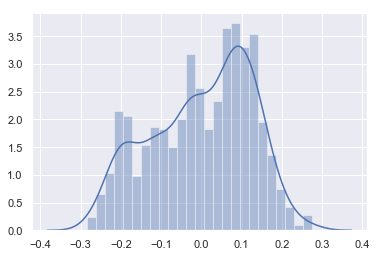

In [157]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25);

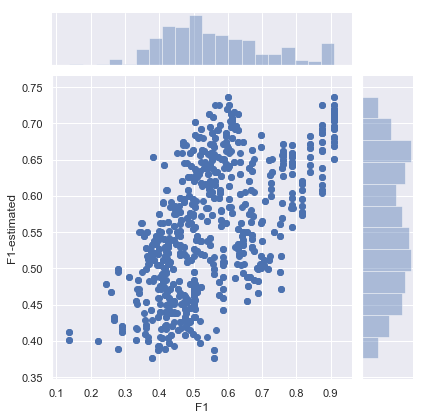

In [158]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));